In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import mplfinance as mpf

In [2]:
source = "yahoo"
days = 1500
end = datetime.now() - pd.Timedelta(days=3)
start = end - pd.Timedelta(days=days)
(start, end)

(datetime.datetime(2018, 5, 14, 20, 0, 30, 535080),
 datetime.datetime(2022, 6, 22, 20, 0, 30, 535080))

In [3]:
pair = "USDJPY"
df=DataReader(f"{pair}=X", source, start=start, end=end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-06-16,135.412003,132.186996,132.421005,132.421005,0.0,132.421005
2022-06-19,135.412003,134.548996,135.276001,135.276001,0.0,135.276001
2022-06-20,136.328995,134.945007,135.087006,135.087006,0.0,135.087006
2022-06-21,136.595001,135.751007,136.268997,136.268997,0.0,136.268997
2022-06-22,136.181000,134.294006,136.024002,136.024002,0.0,136.024002


In [4]:
# なぜかCloseとOpenの値がほぼ同じなため, 修正する
df["Open"]=df["Close"].shift(1)
df["High"]=np.maximum(df["High"], df["Close"])
df["Low"]=np.minimum(df["Low"], df["Close"])
df=df.iloc[1:]

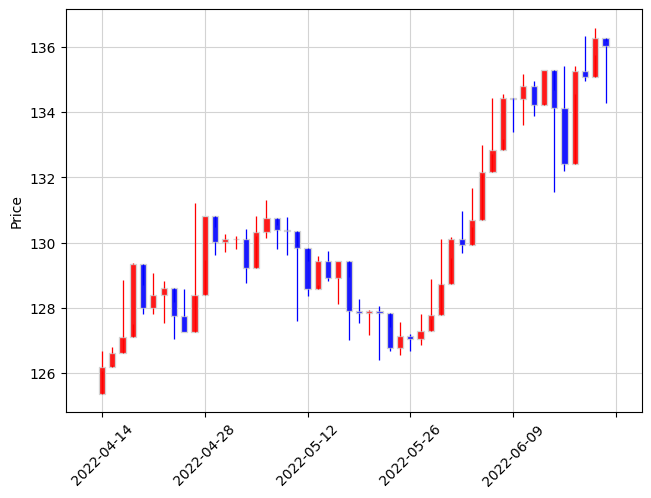

In [5]:
length=50
mc = mpf.make_marketcolors(
    up='red', down='blue', volume='black', edge='lightgray', 
    wick={'up':'red', 'down':'blue'}
)
cs = mpf.make_mpf_style(marketcolors=mc, gridcolor="lightgray")
mpf.plot(df.tail(length), type='candle', datetime_format='%Y-%m-%d', style=cs)

In [6]:
mpf.plot(df.tail(length), type='candle', datetime_format='%Y-%m-%d', style=cs, savefig="img/chart.svg")

# 2通貨の移動相関

In [7]:
pair1="EURJPY"
pair2="AUDNZD"

In [8]:
df1=DataReader(f"{pair1}=X", source, start=start, end=end)
df2=DataReader(f"{pair2}=X", source, start=start, end=end)

In [9]:
x1=(df1["High"]+df1["Low"])/2
x2=(df2["High"]+df2["Low"])/2

In [10]:
print(set(x1.index)-set(x2.index))
print(set(x2.index)-set(x1.index))

set()
set()


In [11]:
x1.corr(x2)

0.4697005570756657

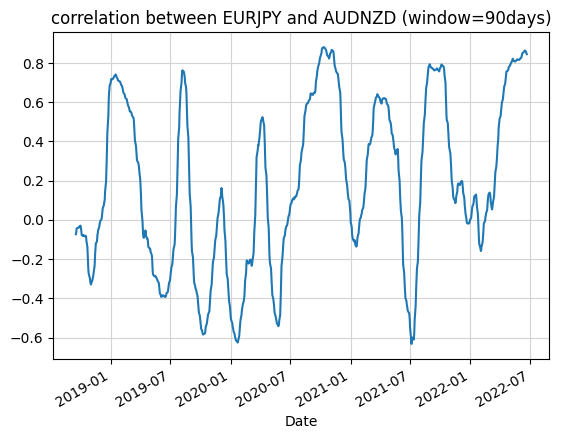

In [12]:
window=90
x1.rolling(window).corr(x2).plot()
plt.title(f"correlation between {pair1} and {pair2} (window={window}days)")
plt.savefig(f"img/{pair1}_{pair2}.svg")

# 通貨ペアの相関

In [13]:
pairs=[
    "CADJPY",
    "EURJPY",
    "AUDNZD",
    "USDCAD",
    "EURGBP",
    "USDJPY",
    "EURUSD",
    "AUDJPY",
    "AUDUSD",
    "NZDJPY",
    "NZDUSD",
    "GBPJPY",
    "GBPUSD",
    "TRYJPY",
    "ZARJPY",
    "MXNJPY",
]

In [14]:
dfs=[DataReader(f"{pair}=X", source, start=start, end=end) for pair in pairs]

In [15]:
serieses=[(df["High"]+df["Low"])/2 for df in dfs]

In [16]:
df=pd.DataFrame(serieses, index=pairs).T

In [17]:
corr=df.corr()

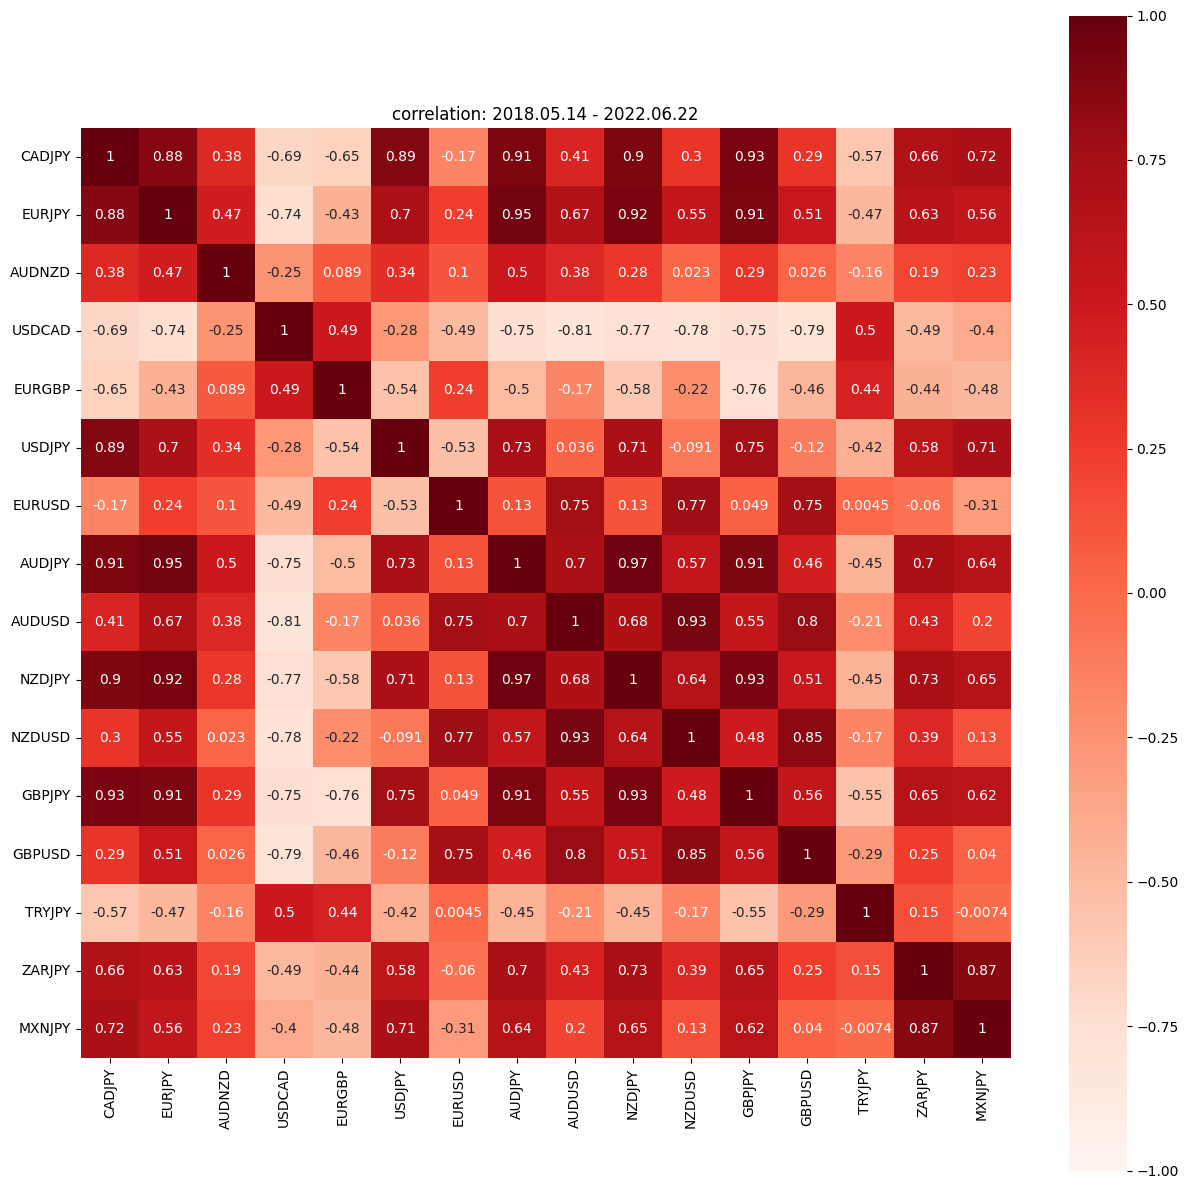

In [18]:
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="Reds", annot=True, vmin = -1, vmax = 1, square=True)
plt.title(f"correlation: {start.strftime('%Y.%m.%d')} - {end.strftime('%Y.%m.%d')}")
plt.savefig("img/corr.svg")